<a href="https://colab.research.google.com/github/yamatai-wizard/GCI_competition1/blob/main/Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. ライブラリ・データ読み込み

In [181]:
!pip install optuna

# Google ColabのGoogleドライブファイル保存用
from google.colab import files

# 基本的なライブラリのインポート
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import re

# グラフ描画用ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

# 機械学習用ライブラリのインポート
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost
import lightgbm
import optuna

# 警告メッセージを非表示にする
import warnings
warnings.filterwarnings("ignore")

In [182]:
# 訓練データとテストデータを読み込み
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
all = pd.concat([df, df_test])
answer = pd.read_csv("answer.csv")
answer["Survived"]

,Survived
0,1
1,0
2,1
3,1
4,0
...,...
413,1
414,0
415,1
416,1


# 1. データの概観・分析・前処理

## 1.1 データの概観

In [183]:
# print(df.shape)
# print(df_test.shape)

In [184]:
# df.head(10)

## 1.2 データの分析

In [185]:
# df.isnull().sum()

In [186]:
# df_test.isnull().sum()

In [187]:
# sns.boxplot(x="Pclass", y="Fare",data=df,showmeans=True)
# plt.show()

# round(df.groupby("Pclass")["Fare"].mean(),2)

In [188]:
# df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand = False)
# df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
# print(df.groupby('Title')['Age'].apply(lambda x: x.isnull().sum()))

# df_test["Title"] = df_test["Name"].str.extract(r" ([A-Za-z]+)\.", expand = False)
# df_test['Title'] = df_test['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
# print(df_test.groupby('Title')['Age'].apply(lambda x: x.isnull().sum()))

# sns.boxplot(x="Title", y="Age",data=df,showmeans=True)
# plt.xlabel("Title")
# plt.ylabel("Age")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# round(df.groupby("Title")["Age"].mean(),2)

In [189]:
# df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
# df["IsAlone"] = (df["FamilySize"]==1).astype(int)

# # 生存率の計算
# survival_rate = df.groupby("IsAlone")["Perished"].mean()
# sample_size = df["IsAlone"].value_counts().sort_index()

# # サブプロット作成
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# # 生存率の円グラフ
# labels = ['With Family (0)', 'Alone (1)']
# colors = ['#ff9999', '#66b3ff']

# ax1.pie(survival_rate,
#         labels=labels,
#         autopct='%1.1f%%',
#         colors=colors,
#         startangle=90,
#         wedgeprops={'edgecolor': 'black'})
# ax1.set_title("Perished Rate by Group", fontsize=14, pad=20)

# # サンプルサイズの棒グラフ
# sns.barplot(x=sample_size.index,
#             y=sample_size.values,
#             palette="pastel",
#             edgecolor="black",
#             ax=ax2)

# ax2.set_xticks([0, 1])
# ax2.set_xticklabels(labels)
# ax2.set_title("Sample Size Comparison", fontsize=14, pad=20)
# ax2.set_xlabel("IsAlone Group", fontsize=12)
# ax2.set_ylabel("Number of Passengers", fontsize=12)

# # 数値ラベルの追加
# for p in ax2.patches:
#     ax2.annotate(f"{p.get_height():.0f}",
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center',
#                 xytext=(0, 5),
#                 textcoords='offset points')

# plt.tight_layout()
# plt.show()

## 1.3 データの前処理

In [190]:
# フォーク元https://www.kaggle.com/code/andreipaulavets/titanic-prediction-0-794-score
def data_cleaner(df):
    df = df.set_index("PassengerId")

    df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand = False)
    df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

    title_age_means = {
        'Mr': 	32.37,
        'Miss': 21.85,
        'Mrs': 35.79,
        'Master': 4.57,
        'Dr': 42.00
    }
    df['Age'].fillna(df['Title'].map(title_age_means), inplace=True)

    df.loc[~df['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master',"Dr"]), 'Title'] = df['Sex'].map({'male': 'Mr', 'female': 'Mrs'})

    df["Embarked"].fillna(df["Embarked"].mode(), inplace=True)

    fare_means = {
        1: 84.15,
        2: 20.66,
        3: 13.68
    }
    df["Fare"].fillna(df["Pclass"].map(fare_means), inplace=True)

    df_sex = pd.get_dummies(df['Sex'], prefix='sex', drop_first=True, dtype=int)
    df_Pclass = pd.get_dummies(df['Pclass'], prefix='class', drop_first=True, dtype=int)
    df_Embarked = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first=True, dtype=int)
    df_Title = pd.get_dummies(df['Title'], prefix='Title', drop_first=False, dtype=int)

    df = pd.concat([df, df_sex, df_Pclass, df_Embarked, df_Title], axis=1)

    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"]==1).astype(int)

    df = df.drop(['Sex','Pclass','Name','Ticket','Embarked','Cabin','Title','SibSp',"Parch"], axis=1)

    return df

In [191]:
df = data_cleaner(df)
df.head()

,Perished,Age,Fare,sex_male,class_2,class_3,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,FamilySize,IsAlone
PassengerId,,,,,,,,,,,,,,,
1,1,22.0,7.2500,1,0,1,0,1,0,0,0,1,0,2,0
2,0,38.0,71.2833,0,0,0,0,0,0,0,0,0,1,2,0
3,0,26.0,7.9250,0,0,1,0,1,0,0,1,0,0,1,1
4,0,35.0,53.1000,0,0,0,0,1,0,0,0,0,1,2,0
5,1,35.0,8.0500,1,0,1,0,1,0,0,0,1,0,1,1


In [192]:
df_test = data_cleaner(df_test)
df_test.head()

,Age,Fare,sex_male,class_2,class_3,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,FamilySize,IsAlone
PassengerId,,,,,,,,,,,,,,
892,34.5,7.8292,1,0,1,1,0,0,0,0,1,0,1,1
893,47.0,7.0000,0,0,1,0,1,0,0,0,0,1,2,0
894,62.0,9.6875,1,1,0,1,0,0,0,0,1,0,1,1
895,27.0,8.6625,1,0,1,0,1,0,0,0,1,0,1,1
896,22.0,12.2875,0,0,1,0,1,0,0,0,0,1,3,0


# 2. ベースラインモデルの構築

In [193]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_test = df_test.iloc[:,:].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [194]:
def objective_rf(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 300),
        "max_depth": trial.suggest_int("max_depth", 8, 13),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42
    }
    rfc = RandomForestClassifier(**param, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(rfc, X_train, y_train, cv=cv, scoring="accuracy").mean()
    return score

# 最適化実行
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective_rf, n_trials=10)

# 最適パラメータの取得
best_params = study.best_params

# 最適パラメータでモデル構築
rfc1 = RandomForestClassifier(
    **best_params,
    n_jobs=-1,
    random_state=42
)

# 全データで学習
rfc1.fit(X_train, y_train)

# 評価
print("RandomForest:\n")
print("Train Score: {}".format(round(rfc1.score(X_train, y_train), 3)))
print("Test Score: {}".format(round(rfc1.score(X_valid, y_valid), 3)))

rfc1_pred = rfc1.predict(X_test)
round(accuracy_score(answer["Survived"], rfc1_pred),3)

[I 2025-06-09 02:10:00,240] A new study created in memory with name: no-name-835f177a-81fd-44d0-844a-c8f629b27a9d
[I 2025-06-09 02:10:05,683] Trial 0 finished with value: 0.8313290322580645 and parameters: {'n_estimators': 206, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8313290322580645.
[I 2025-06-09 02:10:10,177] Trial 1 finished with value: 0.8329806451612903 and parameters: {'n_estimators': 256, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8329806451612903.
[I 2025-06-09 02:10:16,199] Trial 2 finished with value: 0.8409548387096775 and parameters: {'n_estimators': 215, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.8409548387096775.
[I 2025-06-09 02:10:24,291] Trial 3 finished with value: 0.8441806451612903 

RandomForest:

Train Score: 0.875
Test Score: 0.828


0.794

In [195]:
def objective_rf(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 300),
        "max_depth": trial.suggest_int("max_depth", 8, 13),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 8
    }
    rfc = RandomForestClassifier(**param, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
    score = cross_val_score(rfc, X_train, y_train, cv=cv, scoring="accuracy").mean()
    return score

# 最適化実行
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=8))
study.optimize(objective_rf, n_trials=10)

# 最適パラメータの取得
best_params = study.best_params

# 最適パラメータでモデル構築
rfc2 = RandomForestClassifier(
    **best_params,
    n_jobs=-1,
    random_state=8
)

# 全データで学習
rfc2.fit(X_train, y_train)

# 評価
print("RandomForest:\n")
print("Train Score: {}".format(round(rfc2.score(X_train, y_train), 3)))
print("Test Score: {}".format(round(rfc2.score(X_valid, y_valid), 3)))

rfc2_pred = rfc2.predict(X_test)
round(accuracy_score(answer["Survived"], rfc2_pred),3)

[I 2025-06-09 02:10:50,588] A new study created in memory with name: no-name-50f15f06-aeb6-4639-bcb8-4f3ced1396f6
[I 2025-06-09 02:10:56,483] Trial 0 finished with value: 0.8218967741935485 and parameters: {'n_estimators': 281, 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8218967741935485.
[I 2025-06-09 02:11:00,501] Trial 1 finished with value: 0.8395483870967742 and parameters: {'n_estimators': 222, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8395483870967742.
[I 2025-06-09 02:11:04,303] Trial 2 finished with value: 0.8283096774193549 and parameters: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.8395483870967742.
[I 2025-06-09 02:11:12,343] Trial 3 finished with value: 0.84598709677419

RandomForest:

Train Score: 0.902
Test Score: 0.821


0.787

In [196]:
def objective_rf(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 300),
        "max_depth": trial.suggest_int("max_depth", 8, 13),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 50
    }
    rfc = RandomForestClassifier(**param, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
    score = cross_val_score(rfc, X_train, y_train, cv=cv, scoring="accuracy").mean()
    return score

# 最適化実行
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=50))
study.optimize(objective_rf, n_trials=10)

# 最適パラメータの取得
best_params = study.best_params

# 最適パラメータでモデル構築
rfc3 = RandomForestClassifier(
    **best_params,
    n_jobs=-1,
    random_state=50
)

# 全データで学習
rfc3.fit(X_train, y_train)

# 評価
print("RandomForest:\n")
print("Train Score: {}".format(round(rfc3.score(X_train, y_train), 3)))
print("Test Score: {}".format(round(rfc3.score(X_valid, y_valid), 3)))

rfc3_pred = rfc3.predict(X_test)
round(accuracy_score(answer["Survived"], rfc3_pred),3)

[I 2025-06-09 02:11:33,142] A new study created in memory with name: no-name-111e4fa0-af61-4dc6-8035-da064bb580c8
[I 2025-06-09 02:11:36,400] Trial 0 finished with value: 0.836258064516129 and parameters: {'n_estimators': 224, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.836258064516129.
[I 2025-06-09 02:11:38,373] Trial 1 finished with value: 0.8410580645161291 and parameters: {'n_estimators': 196, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8410580645161291.
[I 2025-06-09 02:11:40,640] Trial 2 finished with value: 0.8282064516129031 and parameters: {'n_estimators': 251, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8410580645161291.
[I 2025-06-09 02:11:42,513] Trial 3 finished with value: 0.8250451612903225 

RandomForest:

Train Score: 0.864
Test Score: 0.825


0.792

# 3. 特徴量エンジニアリング

# 4. 様々なモデルの構築・調整

# 5. モデルのアンサンブリング

In [197]:
rfc_pred1 = rfc1.predict_proba(X_test)
rfc_pred2 = rfc2.predict_proba(X_test)
rfc_pred3 = rfc3.predict_proba(X_test)


# 各モデルの検証スコアを取得
val_scores = {
    "rfc1": rfc1.score(X_valid, y_valid),
    "rfc2": rfc2.score(X_valid, y_valid),
    "rfc3": rfc3.score(X_valid, y_valid)
}

# 相対重みを計算
total = sum(val_scores.values())
weights = {k: v/total for k, v in val_scores.items()}

# 重み付き平均
pred_proba = (
    rfc1_pred * weights["rfc1"] +
    rfc2_pred * weights["rfc2"] +
    rfc3_pred * weights["rfc3"]
)

pred = (pred_proba > 0.5).astype(int)
round(accuracy_score(answer["Survived"], pred),3)

0.797

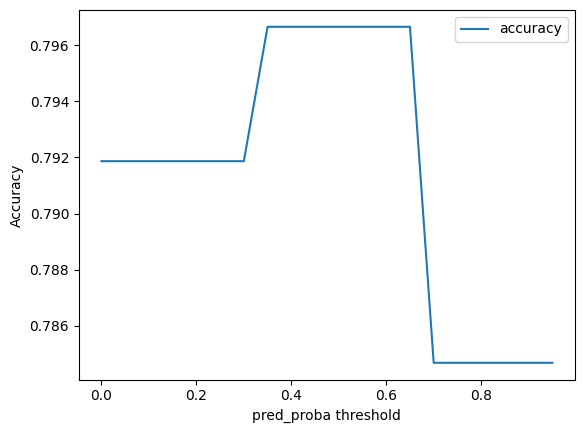

In [198]:
accuracy = []
range = np.arange(0, 1.0, 0.05)

for i in range:
    pred = (pred_proba > i).astype(int)
    acc = accuracy_score(answer["Survived"], pred)
    accuracy.append(acc)

plt.plot(range, accuracy, label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('pred_proba threshold')
plt.legend()
plt.show()

# 6. 予測の出力・提出

In [199]:
# gender_submission.csvファイルを読み込む
submission = pd.read_csv("gender_submission.csv")

# 予測結果を"Perished"列に代入
submission["Perished"] = pred

# 加工したデータをsubmission.csvとして保存（インデックス列は出力しない）
submission.to_csv("submission.csv", index=False)

# Google Colab上でファイルをダウンロード
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>